In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import copy
import time
import tabulate
import numpy as np
sys.path.append(os.path.join(os.path.abspath(""), ".."))

In [3]:
from app.models import Classifier
from app.utils import ImageWrapper 
from app.transforms import FFT, IFFT, CreateOnesMask
from app.filters import CreateKernel, Convolve, Canny, HOG
from app.imager import ImageLoader, DefectViewer, Show, Exposure
from app.custom import RemoveBusBars, Orient, HighlightFrontGrid
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

In [4]:
# Seed used in show to show the same images when num_images option is set
seed = 1234
scores = []
legends = []

In [5]:
# Analyzing which defect 
n_samples = 2000
defect_class = ['FrontGridInterruption', 'NearSolderPad']

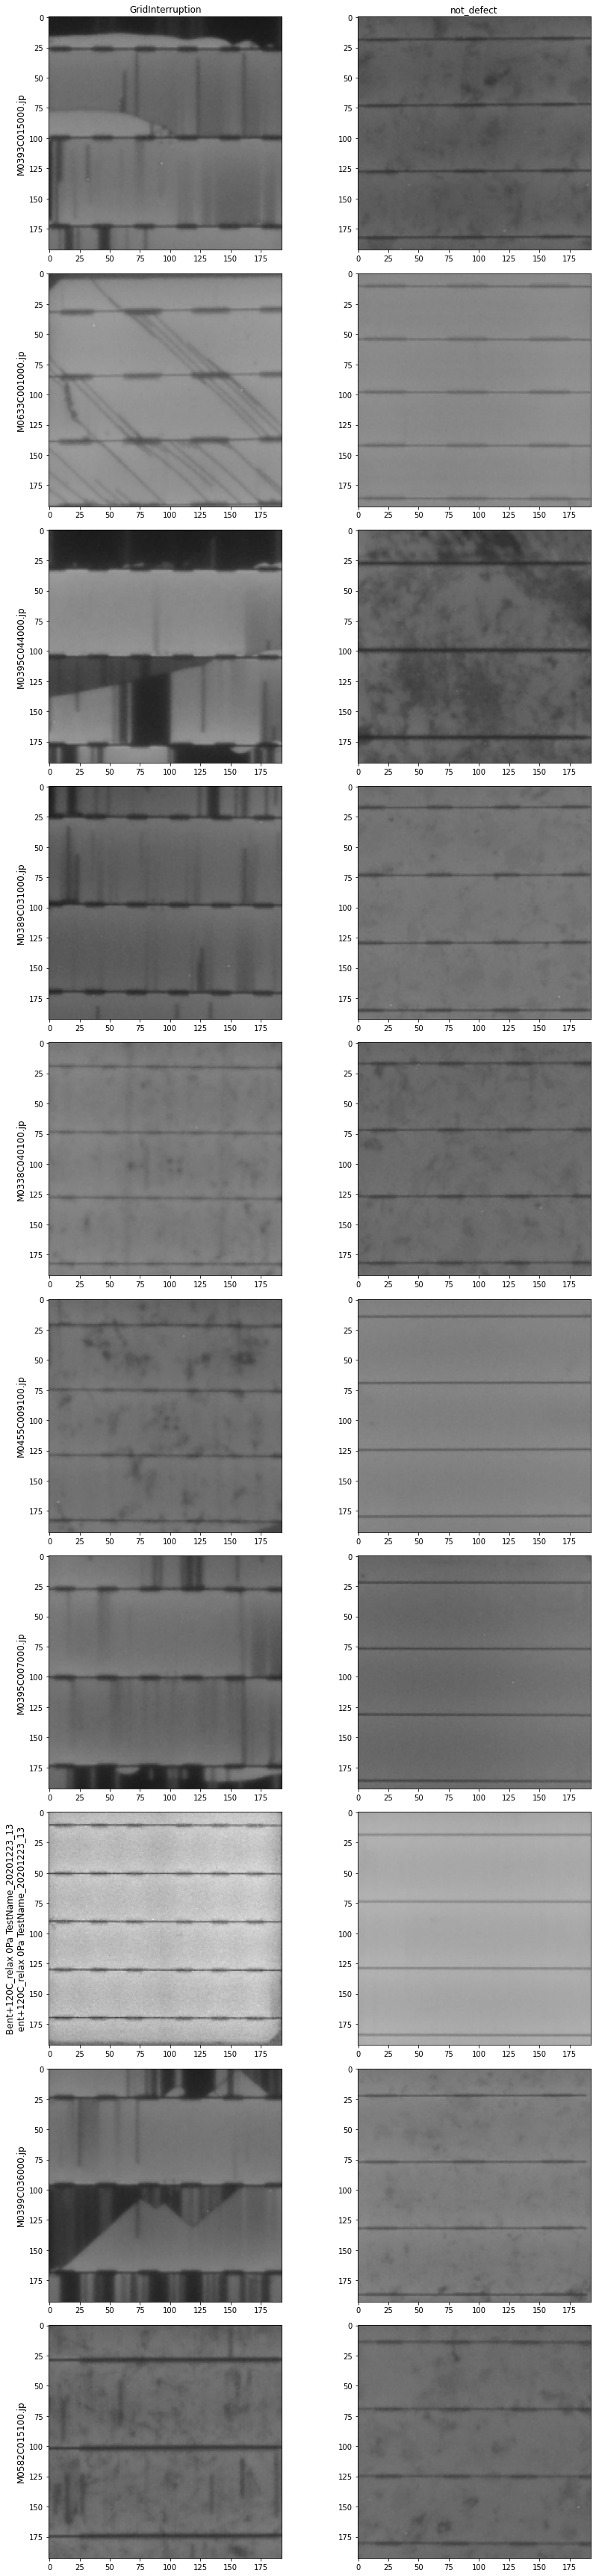

In [6]:
# Load 10 examples and name the category for it. Category is like a title for images
defect_class = defect_class
defect = (DefectViewer(row_chop=15, col_chop=15) << (ImageLoader(defect_class=defect_class) << n_samples))
defect.category = 'GridInterruption'

# Make the other teh same length as the defect
num_samples = len(defect)

# Get the not this defect
# not_defect = (DefectViewer(row_chop=15, col_chop=15) << (ImageLoader(defect_class='FrontGridInterruption', is_not=True) << n_samples))
not_defect = (DefectViewer(row_chop=15, col_chop=15) << (ImageLoader(defect_class='None', is_not=False) << n_samples))
not_defect.category = 'not_defect'

# Create a copy of the defect
defect_ = defect.copy()

# Eliminate any not defect images that are in defect
defect = defect - not_defect

# ELiminate any defect images that are in not defect
not_defect = not_defect - defect_

# View both the defect and the clean class
# I am using a tuple in this case as defect and clean are ImageWrapper objects
# Show random 5 out of the 10 images. Using the seed will ensure the same 5 are shown everytime
_ = Show(num_images=10, seed=seed) << (defect, not_defect)

In [7]:
print(len(defect))
print(len(not_defect))

2000
2000


In [10]:
# 1. Base model on raw data
model_params = {'penalty': 'l2', 'seed': 14376, 'pca_dims': None}
cla = Classifier(defect, not_defect, LogisticRegression, None)
score = cla.fit_cv(**model_params)
print(score)

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

scores.append(score)
legends.append('Baseline Logistic Regression model')

0.8543397665535071
          Pred 0    Pred 1
------  --------  --------
True 0       349        44
True 1        73       334


/home/aswin/anaconda3/envs/w281_final_project/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [11]:
# 2.a Base model on raw data with pca
pca_dims = 100
model_params = {'penalty': 'l2', 'seed': 14376, 'pca_dims': pca_dims}
cla = Classifier(defect, not_defect, LogisticRegression, None)
score = cla.fit_cv(**model_params)
print(score)

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

scores.append(score)
legends.append(f'Logitc regression with {pca_dims} dimensions')

0.8074379028577502
          Pred 0    Pred 1
------  --------  --------
True 0       344        49
True 1       106       301


/home/aswin/anaconda3/envs/w281_final_project/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [12]:
# 2.b Base model on raw data with pca
pca_dims = 200
model_params = {'penalty': 'l2', 'seed': 14376, 'pca_dims': pca_dims}
cla = Classifier(defect, not_defect, LogisticRegression, None)
score = cla.fit_cv(**model_params)
print(score)

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

scores.append(score)
legends.append(f'Logitc regression with {pca_dims} dimensions')

0.8319204006226907
          Pred 0    Pred 1
------  --------  --------
True 0       342        51
True 1        84       323


/home/aswin/anaconda3/envs/w281_final_project/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [13]:
# 2.c Base model on raw data with pca
pca_dims = 400
model_params = {'penalty': 'l2', 'seed': 14376, 'pca_dims': pca_dims}
cla = Classifier(defect, not_defect, LogisticRegression, None)
score = cla.fit_cv(**model_params)
print(score)

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

scores.append(score)
legends.append(f'Logitc regression with {pca_dims} dimensions')

0.8407387262349094
          Pred 0    Pred 1
------  --------  --------
True 0       347        46
True 1        82       325


/home/aswin/anaconda3/envs/w281_final_project/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [14]:
# 2.d Base model on raw data with pca
pca_dims = 800
model_params = {'penalty': 'l2', 'seed': 14376, 'pca_dims': pca_dims}
cla = Classifier(defect, not_defect, LogisticRegression, None)
score = cla.fit_cv(**model_params)
print(score)

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

scores.append(score)
legends.append(f'Logitc regression with {pca_dims} dimensions')

0.8467499421697895
          Pred 0    Pred 1
------  --------  --------
True 0       344        49
True 1        74       333


/home/aswin/anaconda3/envs/w281_final_project/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [15]:
# 2.d Base model on raw data with pca
pca_dims = 2000
model_params = {'penalty': 'l2', 'seed': 14376, 'pca_dims': pca_dims}
cla = Classifier(defect, not_defect, LogisticRegression, None)
score = cla.fit_cv(**model_params)
print(score)

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

scores.append(score)
legends.append(f'Logitc regression with {pca_dims} dimensions')

0.8480222068008327
          Pred 0    Pred 1
------  --------  --------
True 0       345        48
True 1        74       333


/home/aswin/anaconda3/envs/w281_final_project/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [16]:
# 3.a Gradient Boosted Classifier 
pca_dims = 100
params = {'seed': 14376,'n_estimators': 600, 'max_depth': 4, 'learning_rate': 0.05, 'pca_dims': pca_dims}
cla = Classifier(defect, not_defect, GradientBoostingClassifier, None)
     
# When done, return the score 
score = cla.fit_cv(**params)
print(score)

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

scores.append(score)
legends.append(f'Gradient Boosted Classifier model with {pca_dims} dimensions')

0.8767153690817813
          Pred 0    Pred 1
------  --------  --------
True 0       355        38
True 1        61       346


In [17]:
# 3.b Gradient Boosted Classifier 
pca_dims = 200
params = {'seed': 14376,'n_estimators': 600, 'max_depth': 4, 'learning_rate': 0.05, 'pca_dims': pca_dims}
cla = Classifier(defect, not_defect, GradientBoostingClassifier, None)
     
# When done, return the score 
score = cla.fit_cv(**params)
print(score)

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

scores.append(score)
legends.append(f'Gradient Boosted Classifier model with {pca_dims} dimensions')

0.8818044276059543
          Pred 0    Pred 1
------  --------  --------
True 0       359        34
True 1        61       346


In [18]:
# 3.c Gradient Boosted Classifier 
pca_dims = 400
params = {'seed': 14376,'n_estimators': 600, 'max_depth': 4, 'learning_rate': 0.05, 'pca_dims': pca_dims}
cla = Classifier(defect, not_defect, GradientBoostingClassifier, None)
     
# When done, return the score 
score = cla.fit_cv(**params)
print(score)

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

scores.append(score)
legends.append(f'Gradient Boosted Classifier model with {pca_dims} dimensions')

0.870178992316397
          Pred 0    Pred 1
------  --------  --------
True 0       346        47
True 1        57       350


## Fix orientation of images

In [ ]:
from app.custom import Orient
# Get the oriented images and HOG
start = time.perf_counter()
oriented_defect = Orient(num_jobs=20, do_debug=False, do_eliminate=False) << defect
oriented_not_defect = Orient(num_jobs=20, do_debug=False, do_eliminate=False) << not_defect
print(time.perf_counter() - start)

# View both the defect and the clean class
# I am using + operator as oriented_defect and oriented_clean are tuples
_ = Show(num_images=10, seed=seed) << oriented_defect + oriented_not_defect

In [20]:
# 5. Gradient Boosted classifier on oriented defects
pca_dims = 200
params = {'seed': 14376,'n_estimators': 600, 'max_depth': 4, 'learning_rate': 0.05, 'pca_dims': pca_dims}
cla = Classifier(oriented_defect[-1], oriented_not_defect[-1], GradientBoostingClassifier, None)
     
# When done, return the score 
score = cla.fit_cv(**params)
print(score)

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

scores.append(score)
legends.append(f'Gradient Boosted Classifier model with {pca_dims} dimensions and re-oriented images')

0.8678095166644786
          Pred 0    Pred 1
------  --------  --------
True 0       348        45
True 1        61       346


In [ ]:
for misclass in out:
    _ = Show(num_images=10, seed=seed) << misclass[-1]

# Sobel Filter

In [21]:
defect_kernel = CreateKernel(kernel='sobel', axis=0) << oriented_defect
not_defect_kernel = CreateKernel(kernel='sobel', axis=0) << oriented_not_defect

sobel_defect = Convolve() << defect_kernel
sobel_not_defect = Convolve() << not_defect_kernel

In [ ]:
_ = Show(num_images=10, seed=seed) << sobel_defect +  sobel_not_defect

In [23]:
pca_dims = 100
params = {'seed': 14376,'n_estimators': 600, 'max_depth': 4, 'learning_rate': 0.05, 'pca_dims': pca_dims}
cla = Classifier(oriented_defect[-1] & sobel_defect[-1], oriented_not_defect[-1] & sobel_not_defect[-1], GradientBoostingClassifier, None)
     
# When done, return the score 
score = cla.fit_cv(**params)
print(score)

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

scores.append(score)
legends.append(f'Gradient Boosted Classifier model with {pca_dims} dimensions and Sobel images')

0.8790848447336996
          Pred 0    Pred 1
------  --------  --------
True 0       353        40
True 1        57       350


In [ ]:
pca_dims = 200
params = {'seed': 14376,'n_estimators': 600, 'max_depth': 4, 'learning_rate': 0.05, 'pca_dims': pca_dims}
cla = Classifier(oriented_defect[-1] & sobel_defect[-1], oriented_not_defect[-1] & sobel_not_defect[-1], GradientBoostingClassifier, None)
     
# When done, return the score 
score = cla.fit_cv(**params)
print(score)

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

scores.append(score)
legends.append(f'Gradient Boosted Classifier model with {pca_dims} dimensions and Sobel images')

In [24]:
pca_dims = 400
params = {'seed': 14376,'n_estimators': 600, 'max_depth': 4, 'learning_rate': 0.05, 'pca_dims': pca_dims}
cla = Classifier(oriented_defect[-1] & sobel_defect[-1], oriented_not_defect[-1] & sobel_not_defect[-1], GradientBoostingClassifier, None)
     
# When done, return the score 
score = cla.fit_cv(**params)
print(score)

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

scores.append(score)
legends.append(f'Gradient Boosted Classifier model with {pca_dims} dimensions and Sobel images')

0.885533694694
          Pred 0    Pred 1
------  --------  --------
True 0       360        33
True 1        59       348


In [9]:
for misclass in out:
    _ = Show(num_images=40, seed=seed) << misclass[-1]

NameError: name 'out' is not defined

## Highlight the front grid

In [39]:
# Remove the BusBars
front_grid_params = {'finger_width': 3, 'finger_height': 3, 'side_padding': 2, 
                     'top_padding': 0, 'bottom_padding': 0, 'finger_mult': 1, 
                     'flipped': False, 'num_jobs': 40}
grid_oriented_defect = HighlightFrontGrid(**front_grid_params) << oriented_defect
grid_oriented_not_defect = HighlightFrontGrid(**front_grid_params) << oriented_not_defect

In [40]:
defect_ = oriented_defect[-1] & sobel_defect[-1] & grid_oriented_defect[-1]
not_defect_ = oriented_not_defect[-1] & sobel_not_defect[-1] & grid_oriented_not_defect[-1]

In [41]:
pca_dims = 50
params = {'seed': 14376,'n_estimators': 600, 'max_depth': 4, 'learning_rate': 0.05, 'pca_dims': pca_dims}
cla = Classifier(defect_, not_defect_, GradientBoostingClassifier, None)
     
# When done, return the score 
score = cla.fit_cv(**params)
print(score)

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

scores.append(score)
legends.append(f'Gradient Boosted Classifier model with {pca_dims} dimensions and sobel + custom kernel_3')

0.8506980262705454
          Pred 0    Pred 1
------  --------  --------
True 0       350        43
True 1        77       330


In [38]:
print(legends)
scores[-5]

['Baseline Logistic Regression model', 'Logitc regression with 100 dimensions', 'Logitc regression with 200 dimensions', 'Logitc regression with 400 dimensions', 'Logitc regression with 800 dimensions', 'Logitc regression with 2000 dimensions', 'Gradient Boosted Classifier model with 100 dimensions', 'Gradient Boosted Classifier model with 200 dimensions', 'Gradient Boosted Classifier model with 400 dimensions', 'Gradient Boosted Classifier model with 200 dimensions and re-oriented images', 'Gradient Boosted Classifier model with 200 dimensions and Sobel images', 'Gradient Boosted Classifier model with 100 dimensions and Sobel images', 'Gradient Boosted Classifier model with 400 dimensions and Sobel images', 'Gradient Boosted Classifier model with 50 dimensions and sobel + custom kernel', 'Gradient Boosted Classifier model with 100 dimensions and sobel + custom kernel', 'Gradient Boosted Classifier model with 200 dimensions and sobel + custom kernel', 'Gradient Boosted Classifier model

0.864517883601853

In [28]:
pca_dims = 100
params = {'seed': 14376,'n_estimators': 600, 'max_depth': 4, 'learning_rate': 0.05, 'pca_dims': pca_dims}
cla = Classifier(defect_, not_defect_, GradientBoostingClassifier, None)
     
# When done, return the score 
score = cla.fit_cv(**params)
print(score)

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

scores.append(score)
legends.append(f'Gradient Boosted Classifier model with {pca_dims} dimensions and sobel + custom kernel')

0.8672812298766497
          Pred 0    Pred 1
------  --------  --------
True 0       364        29
True 1        78       329


In [29]:
pca_dims = 200
params = {'seed': 14376,'n_estimators': 600, 'max_depth': 4, 'learning_rate': 0.05, 'pca_dims': pca_dims}
cla = Classifier(defect_, not_defect_, GradientBoostingClassifier, None)
     
# When done, return the score 
score = cla.fit_cv(**params)
print(score)

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

scores.append(score)
legends.append(f'Gradient Boosted Classifier model with {pca_dims} dimensions and sobel + custom kernel')

0.8732924458115299
          Pred 0    Pred 1
------  --------  --------
True 0       361        32
True 1        70       337


In [30]:
pca_dims = 400
params = {'seed': 14376,'n_estimators': 600, 'max_depth': 4, 'learning_rate': 0.05, 'pca_dims': pca_dims}
cla = Classifier(defect_, not_defect_, GradientBoostingClassifier, None)
     
# When done, return the score 
score = cla.fit_cv(**params)
print(score)

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

scores.append(score)
legends.append(f'Gradient Boosted Classifier model with {pca_dims} dimensions and sobel + custom kernel')

0.869431888515858
          Pred 0    Pred 1
------  --------  --------
True 0       357        36
True 1        69       338


## Deep Neural net models

In [42]:
defect_dnn = oriented_defect[-1] & sobel_defect[-1]
not_defect_dnn = oriented_not_defect[-1] & sobel_not_defect[-1]

In [52]:
from app.models import ModelNN

lr = 0.0001
pca_dims = 1000
if pca_dims is None:
    dense_layers = (2000, 1000, 300, 300, 300)
else:
    dense_layers = (pca_dims, int(pca_dims/2), int(pca_dims/2), int(pca_dims/2), int(pca_dims/2))

optimizer_params = {'name': 'sgd', 'lr': lr, 'nesterov': False, 'momentum': 0.9}
scheduler_params = {'lr_min': lr/100, 't_mul': 2}
model_params = {'num_output_classes': 2, 'dense_layers': (2000, 1000, 300, 300, 300), 'dense_activation': 'relu', 
                'pca_dims': pca_dims, 'dropout': 0.2}

# model = ModelNN(defect, not_defect, model_params, optimizer_params, scheduler_params, model_type='dnn')
model = ModelNN(defect_dnn, not_defect_dnn, model_params, optimizer_params, scheduler_params, model_type='dnn')
score = model.fit(num_epochs=30)

print(score)
scores.append(score)
legends.append(f'DNN with {pca_dims} dims on enhanced images')

Epoch 0 train loss 0.6233765792846679 val loss 0.5997023200988769 lr [9.97342251935759e-05]
Epoch 1 train loss 0.5342848053574563 val loss 0.6048573732376099 lr [9.892905705441663e-05]
Epoch 2 train loss 0.49944857954978944 val loss 0.6016680121421814 lr [9.759329003173744e-05]
Epoch 3 train loss 0.458143453001976 val loss 0.5954061222076416 lr [9.574155906856602e-05]
Epoch 4 train loss 0.45118395298719405 val loss 0.586935385465622 lr [9.339415211683454e-05]
Epoch 5 train loss 0.43437193796038626 val loss 0.5722177243232727 lr [9.05767878583326e-05]
Epoch 6 train loss 0.4146427996456623 val loss 0.5818074202537536 lr [8.732033392544774e-05]
Epoch 7 train loss 0.39388389974832533 val loss 0.5688080430030823 lr [8.366046870892545e-05]
Epoch 8 train loss 0.38511936709284783 val loss 0.5647679352760315 lr [7.963729045795398e-05]
Epoch 9 train loss 0.3781580041348934 val loss 0.5521654093265533 lr [7.529487795535515e-05]
Epoch 10 train loss 0.37336644396185875 val loss 0.5536853003501893 l

## CNN on the original images

In [57]:
from app.models import ModelNN

lr = 0.0002
optimizer_params = {'name': 'sgd', 'lr': lr, 'nesterov': True, 'momentum': 0.9}
scheduler_params = {'lr_min': lr/100, 't_mul': 3}
model_params = {'num_output_classes': 2, 'channels': ((1, 5), (10, 3), (10, 3), (10, 3), (10, 3)), 'dense_layers': (1000, 500, 500)}

model = ModelNN(oriented_defect[-1], oriented_not_defect[-1], model_params, optimizer_params, scheduler_params, model_type='cnn')

score = model.fit(num_epochs=30)

print(score)

scores.append(score)
legends.append('CNN on oriented images')

Epoch 0 train loss 0.6824552857875824 val loss 0.6703609871864319 lr [0.0001994684503871518]
Epoch 1 train loss 0.6520398074388504 val loss 0.6338394498825073 lr [0.00019785811410883325]
Epoch 2 train loss 0.6201687699556351 val loss 0.6014328265190124 lr [0.00019518658006347487]
Epoch 3 train loss 0.5941440504789353 val loss 0.575349395275116 lr [0.00019148311813713204]
Epoch 4 train loss 0.5725100526213646 val loss 0.5523198115825653 lr [0.0001867883042336691]
Epoch 5 train loss 0.5527173772454261 val loss 0.5309668111801148 lr [0.0001811535757166652]
Epoch 6 train loss 0.5334405130147934 val loss 0.5063928031921386 lr [0.00017464066785089548]
Epoch 7 train loss 0.5146482935547829 val loss 0.49678876757621765 lr [0.0001673209374178509]
Epoch 8 train loss 0.49582520991563794 val loss 0.47648305892944337 lr [0.00015927458091590795]
Epoch 9 train loss 0.4772598120570183 val loss 0.4813820970058441 lr [0.0001505897559107103]
Epoch 10 train loss 0.4599780461192131 val loss 0.4910512304306

In [58]:
import pickle
import random
with open(f'results_{random.randint(0, 2**32)}', 'wb') as outfi:
    pickle.dump((scores, legends), outfi)

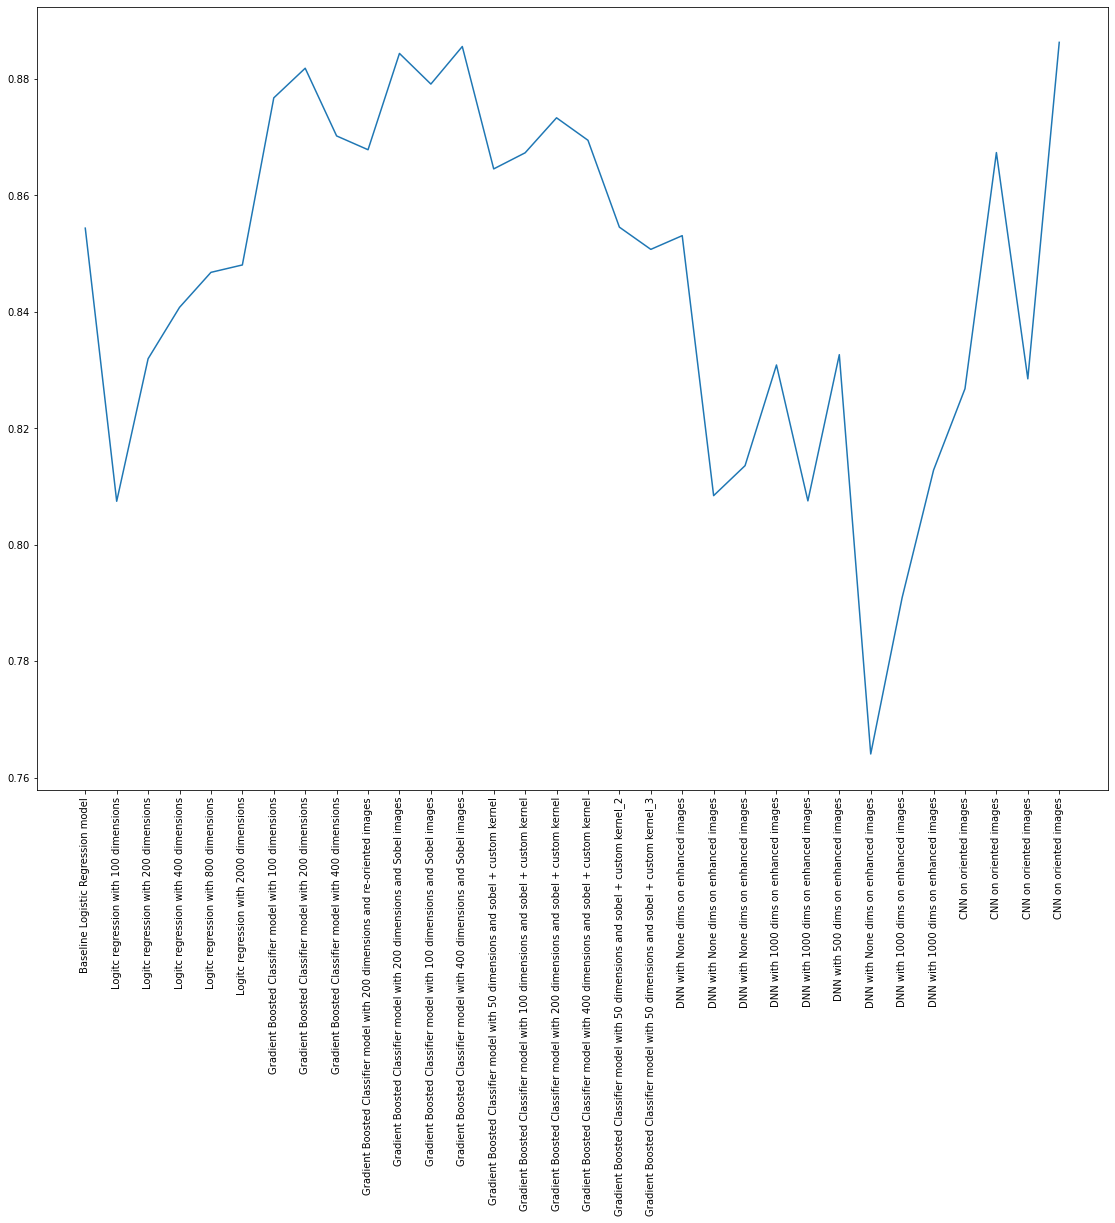

In [59]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(scores))
y = np.array(scores)
plt.figure(figsize=(6.4*3, 4.8*3))
plt.xticks(x, legends, rotation=90, fontsize=20)
plt.plot(x, y, '-')
plt.show()

In [1]:
import pickle
scores, legends = pickle.load(open('results_2100389551', 'rb'))

In [2]:
indices = [0, 5, 6, 7, 8, 11, 12, -1]
new_legends = []
new_scores = []
for index in indices:
    new_legends.append(legends[index])
    new_scores.append(scores[index])

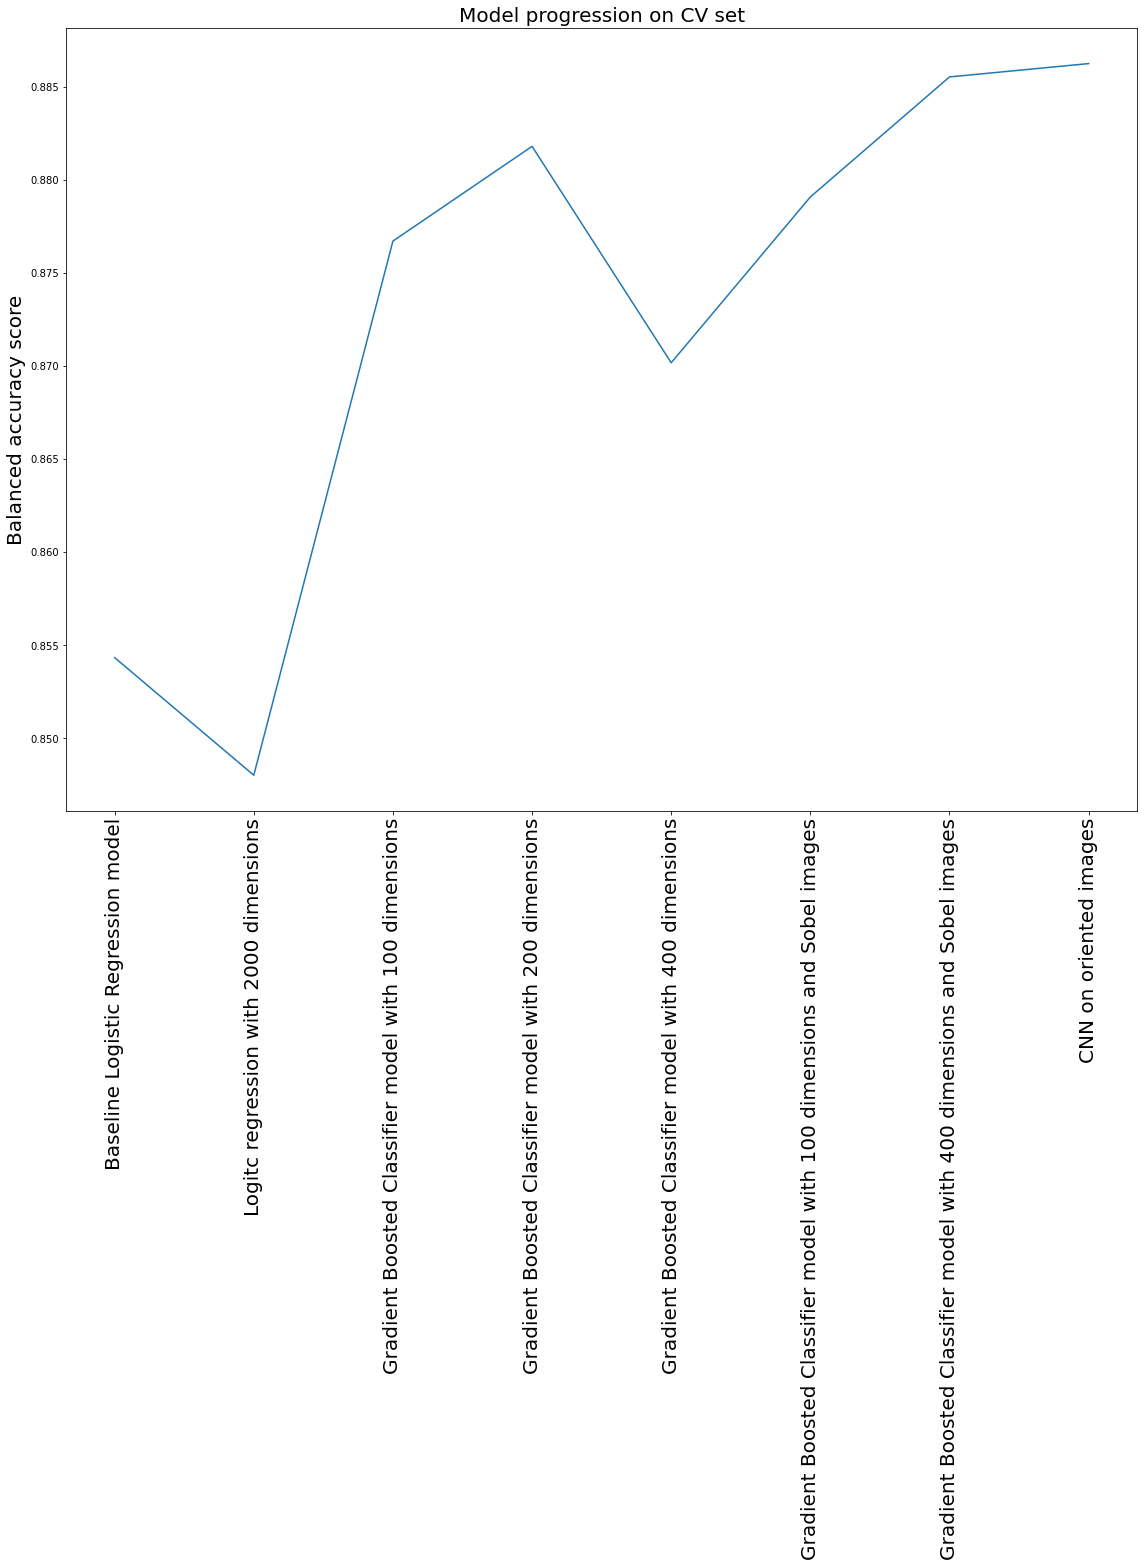

In [6]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(new_scores))
y = np.array(new_scores)
plt.figure(figsize=(6.4*3, 4.8*3))
plt.xticks(x, new_legends, rotation=90, fontsize=20)
plt.plot(x, y, '-')
plt.title('Model progression on CV set', fontsize=20)
plt.ylabel('Balanced accuracy score', fontsize=20)
plt.show()

In [ ]:
raise KeyError("Ended")

In [ ]:
images = ~oriented_defect[-1]

In [ ]:
images.shape

In [ ]:
# mask = 1 - CreateOnesMask(images).horizontal_from_center(left_width=96, right_width=96, height=10, val=0)
mask = 1 - CreateOnesMask(images).vertical_from_center(top_height=96, bottom_height=96, width=10, val=0)

In [ ]:
masked_images = (IFFT(mask=mask) << (FFT(window=None) << oriented_defect))

In [ ]:
_ = Show(num_images=10, seed=seed) << (oriented_defect[-1], masked_images[-1])

## 

In [ ]:
params = {'seed': 14376,'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.05, 'pca_dims': 250}
# cla = Classifier(grid_defect[-1] & defect, grid_not_defect[-1] & not_defect, GradientBoostingClassifier, None)
cla = Classifier(oriented_defect[-1] & grid_oriented_defect[-1], oriented_not_defect[-1] & grid_oriented_not_defect[-1], GradientBoostingClassifier, None)
     
# When done, return the score 
score = cla.fit(**params)
print(score)

In [ ]:
start = time.perf_counter()
front_grid_params = {'finger_width': 4, 'finger_height': 5, 'side_padding': 2, 'top_padding': 0, 'bottom_padding': 0, 'finger_mult': 1, 'flipped': False, 'num_jobs': 20}
clean = (DefectViewer(row_chop=15, col_chop=15) << (ImageLoader(defect_class='None', is_not=False) << 10000))
oriented_clean= Orient(num_jobs=20) << clean
oriented_grid_clean = HighlightFrontGrid(**front_grid_params) << oriented_clean
print(time.perf_counter()-start)

In [ ]:
concat_clean = oriented_clean[-1] & oriented_grid_clean[-1]

In [ ]:
y_vals = cla.predict(oriented_clean[-1] & oriented_grid_clean[-1])

In [ ]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [ ]:
segmented = pd.read_csv('../data/andi_segmented.csv').set_index('filename')

In [ ]:
def display_get_input(img):
    """
    """
    plt.figure(figsize=(6.4*1.5, 4.8*1.5))
    plt.imshow(img, cmap='gray')
    plt.show()
    a = input()
    plt.close()
    clear_output()
    
    return a

In [ ]:
count = 0
y_count = 0
for y, filename, image  in zip(y_vals, concat_clean.image_labels, concat_clean.images):
    if y and np.any(segmented.at[filename, 'clean']):
        
        a = display_get_input(image)
        if a == 'y':
            segmented.at[filename, 'clean'] = False
            count += 1
            print(f'Count is {count} y-count is {y_count}')
    elif y:
        y_count += 1

In [ ]:
segmented.to_csv('../data/andi_segmented.csv')

## Clean up None

In [ ]:
for i in range(out[0][0].images.shape[0]):
    image = out[0][0].images[i, :, :]
    filename = out[0][0].image_labels[i]
    a = display_get_input(image)
    if a == 't':
        segmented.at[filename, 'clean'] = False

In [ ]:
segmented.to_csv('../data/andi_segmented.csv')

## Cleanup front grid

In [ ]:
keep_front_grid = []

In [ ]:
import cv2
def display_get_input(filename):
    """
    """
    if os.path.exists(f'../data/images/train/{filename}'):
        filepath = f'../data/images/train/{filename}'
    else:
        filepath = f'../data/images/test/{filename}'

    image = cv2.cvtColor(cv2.imread(filepath), cv2.COLOR_BGR2GRAY)
    
    plt.figure(figsize=(6.4*1.5, 4.8*1.5))
    plt.imshow(image, cmap='gray')
    plt.show()
    a = input()
    plt.close()
    clear_output()
    
    return a

In [ ]:

annotations_df = pd.read_csv("../data/processed_annotations.csv")
annotations_df = annotations_df[annotations_df['defect_class'] == 'FrontGridInterruption']
annotations_df = annotations_df.groupby('filename').head(1)
annotations_df = annotations_df.sample(frac=1)

In [ ]:
frontgrid_df = annotations_df[annotations_df['filename'].isin(keep_front_grid)]

In [ ]:
# frontgrid_df.to_csv('../data/front_grid.csv')

## Previous work

In [ ]:
# Remove the BusBars
nobus_defect = RemoveBusBars() << oriented_defect
nobus_clean = RemoveBusBars() << oriented_clean

_ = Show(num_images=5, seed=seed) << nobus_defect + nobus_clean

In [ ]:
front_grid_defect = HighlightFrontGrid() << nobus_defect
front_grid_clean = HighlightFrontGrid() << nobus_clean

_ = Show(num_images=15, seed=seed) << front_grid_defect + front_grid_clean

In [ ]:
sigmoid_defect = Exposure('dynamic_sigmoid', cutoff=0.6, gain=50) << front_grid_defect
sigmoid_clean = Exposure('dynamic_sigmoid', cutoff=0.6, gain=50) << front_grid_clean

_ = Show(num_images=10, seed=seed) << (defect, ) + sigmoid_defect + (clean,) + sigmoid_clean

In [ ]:
hog_front_defect = HOG(pixels_per_cell=(5, 5), num_jobs=20) << sigmoid_defect
hog_front_clean = HOG(pixels_per_cell=(5, 5), num_jobs=20) << sigmoid_clean

_ = Show(num_images=10, seed=seed) << (defect, ) + hog_front_defect + (clean,) + hog_front_clean

## Model 

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
# 1. Base model on raw data
model_params = {'penalty': 'l2', 'seed': 14376, 'pca_dims': 100}
cla = Classifier(defect, clean, LogisticRegression, None)
score = cla.fit(**model_params)
print(score)

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

In [ ]:
# 2. HOG on RAW data
model_params = {'penalty': 'l2', 'seed': 14376, 'pca_dims': 100, 'num_jobs': 20}
cla = Classifier(defect, clean, LogisticRegression, HOG)
score = cla.fit(**model_params)
print(score)

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

In [ ]:
for imw in out:
    print(imw[-1].images.shape[0])
    Show(num_images=20) << imw

In [ ]:
# 3. HOG on rotated data
model_params = {'penalty': 'l2', 'seed': 14376, 'pca_dims': 100, 'num_jobs': 20}
cla = Classifier(oriented_defect[-1], oriented_clean[-1], LogisticRegression, HOG)
score = cla.fit(**model_params)
print(score)

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

In [ ]:
# 4. HighlightFrontGrid on rotated data
model_params = {'penalty': 'l2', 'seed': 14376, 'pca_dims': 100, 'num_jobs': 20, 'reduce_max': 1, 'finger_mult': 1}
cla = Classifier(oriented_defect[-1], oriented_clean[-1], LogisticRegression, HighlightFrontGrid)
score = cla.fit(**model_params)
print(score)

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

In [ ]:
for imw in out:
    print(imw[-1].images.shape[0])
    Show(num_images=20) << imw

## End of completed work

In [ ]:
# params = {'seed': 14376,'penalty': 'l2', 'pca_dims': 238, 'num_jobs': 20, 'reduce_max': 1, 
#           'finger_mult': 52.28, 'padding_mult': 17, 'max_finger_width': 3, 'finger_height': 43}
params = {'seed': 14376,'penalty': 'l2', 'pca_dims': 200, 'num_jobs': 20, 'reduce_max': 1, 
          'finger_mult': 50, 'padding_mult': 4, 'max_finger_width': 4, 'finger_height': 20}
cla = Classifier(defect, oriented_clean[-1], LogisticRegression, HighlightFrontGrid)
     
# When done, return the score 
score = cla.fit(**params)
print(score)

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

for imw in out:
    print(imw[-1].images.shape[0])
    Show(num_images=20) << imw